<a href="https://colab.research.google.com/github/pingwx/ya.prac/blob/main/11_Numerical_methods/11_EN_Numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determining the cost of cars

Service for the sale of used cars "Ne bit ne krashen" is developing an application to attract new customers. In it, customer can quickly find out the market value of his car. We have historical data at our disposal: technical characteristics, configurations and prices of cars. We need to build a model to determine the cost.

The customer needs a model with:

- high quality of prediction;
- high prediction speed;
- low fitting time.

**Data Description:**

The data is in the `/datasets/autos.csv` file.

*Features*

- `DateCrawled` — date of downloading the ad from the database
- `VehicleType` — car body type
- `RegistrationYear` - year of car registration
- `Gearbox` — gearbox type
- `Power` - power (hp)
- `Model` — car model
- `Kilometer` — mileage (km)
- `RegistrationMonth` — car registration month
- `FuelType` — fuel type
- `Brand` — car brand
- `NotRepaired` - was the car under repair or not
- `DateCreated` — date of creation of the ad
- `NumberOfPictures` - the number of photos of the car
- `PostalCode` — postal code of the owner of the profile (user)
- `LastSeen` — date of last user activity

*Target feature*

- `Price` — price (euro)

## Data preparation

### Loading data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import numpy as np
import warnings

In [4]:
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/content/autos.csv')

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

The data has been loaded, we see gaps in several columns: vehicletype, gearbox, model, fueltype, notrepaired. Let's convert the column names to lowercase

In [8]:
df.columns = [col.lower() for col in df.columns]

### Pre-processing and analysis

Let's take a closer look at each of the features and analyze them

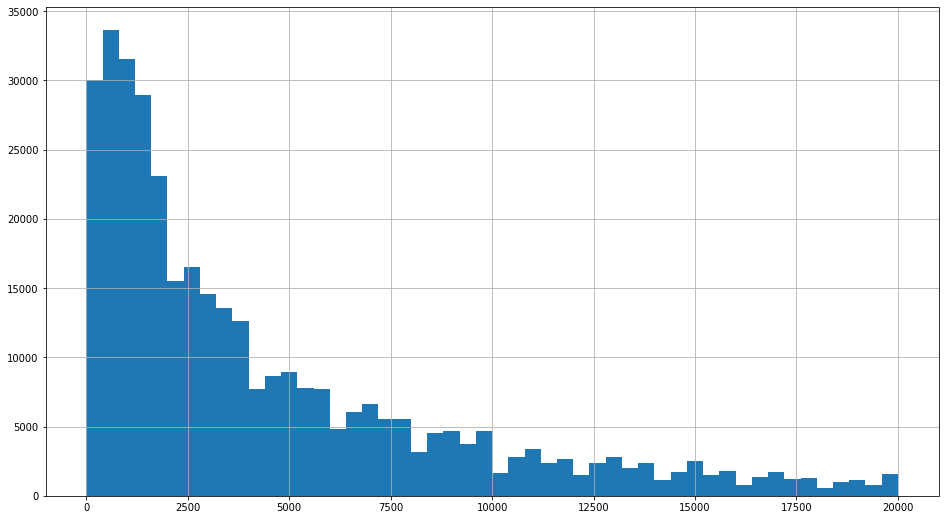

In [9]:
df['price'].hist(figsize=(16,9),bins=50);

In [10]:
df['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [11]:
len(df.query('price == 0'))

10772

We will consider rows with a price value equal to zero as gaps, since we logically assume that the price of a car is a non-zero value. Let's remove these lines.

In [12]:
df = df.drop(df.query('price == 0').index)

Lets look at the distribution of the low price ads

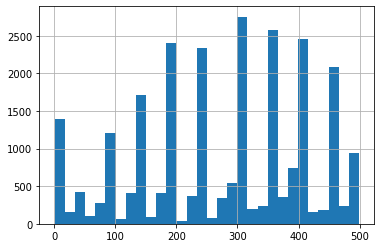

In [13]:
df.query('price < 500')['price'].hist(bins=30);

We will also assume that the ad with the price lower than 100 euros are also invalid.

In [14]:
df = df.drop(df.query('price < 100').index)

Let's convert the datecrawled column to datetime.

In [15]:
try:
    df['datecrawled'] = pd.to_datetime(df['datecrawled'])
    print('success')
except:
    print('some error happened')

success


In [16]:
df['datecrawled'].describe()

count                  341055
unique                 263688
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: datecrawled, dtype: object

We will not consider the datecrawled column as a feature, however, we note that the last downloaded ad is dated April 2016, if we see a date greater than this value, it will most likely be incorrect

In [17]:
df['vehicletype'].value_counts()

sedan          89087
small          77444
wagon          63465
bus            28265
convertible    19817
coupe          15555
suv            11762
other           3048
Name: vehicletype, dtype: int64

In the vehicletype column, we see several categorical values. The gaps will later be filled in with the value "unknown", which will be one additional category.

In [18]:
df['registrationyear'].describe()

count    341055.000000
mean       2003.955303
std          69.811742
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

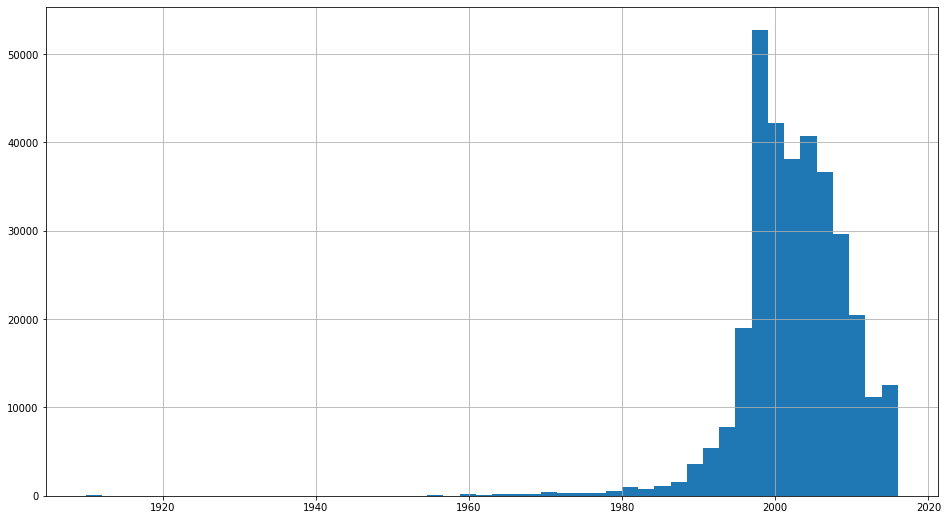

In [19]:
df.query('registrationyear < 2017 and registrationyear > 1900')['registrationyear'].hist(bins=50, figsize=(16,9));

We see the year of registration can take impossible values from 1000 to 9999. Since the date of downloading profiles in this dataset refers to 2016, we will consider values > 2017 as impossible. We will not cosider the values below 1950 as valid also

In [20]:
len(df.query('registrationyear <= 1950 or registrationyear >=2017'))

13846

We will ruthlessly delete these lines.

In [21]:
df = df.drop(df.query('registrationyear < 1950 or registrationyear >=2017').index)

In [22]:
df['gearbox'].value_counts()

manual    249852
auto       62809
Name: gearbox, dtype: int64

This column also contains gaps, we will also fill them with the value "unknown" later.

In [23]:
df['power'].describe()

count    327223.000000
mean        112.360943
std         185.292743
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

We see the maximum value of the power column being 20000, which is impossible.

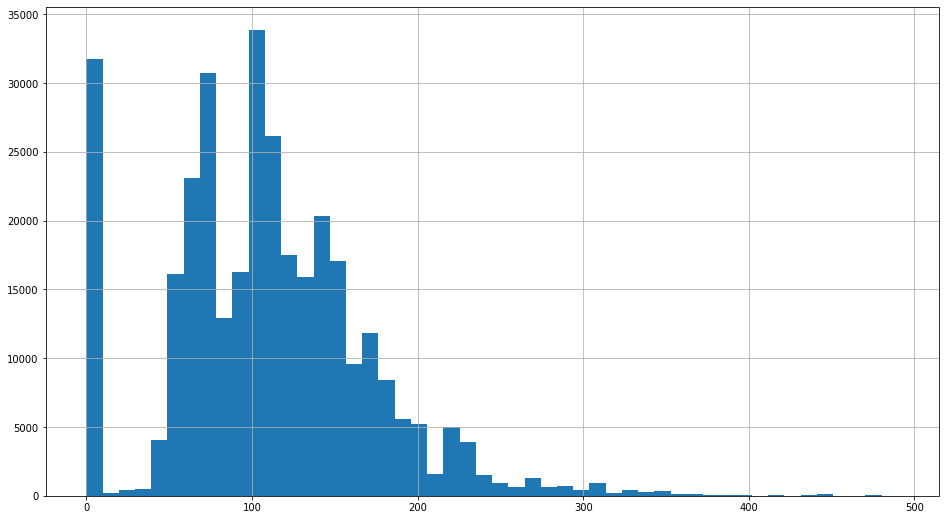

In [24]:
df.query('power < 500')['power'].hist(bins=50, figsize=(16,9));

We also see a fairly large number of zero values, we consider them gaps, because the zero values in this column are logically incorrect. Filling these gaps with some other value (median, mean) is not possible, because in this way we will distort the data. Let's drop columns with a zero value of power and a value of more than 500 from the dataset.

In [25]:
len(df.query('power > 500 or power == 0'))

31942

In [26]:
df = df.drop(df.query('power > 500 or power == 0').index)

As in the case with the price, lets look at the distribution of the features for small values.

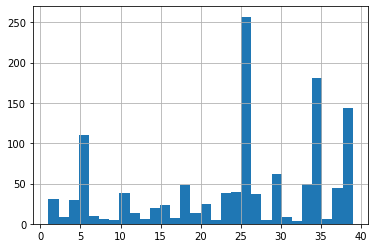

In [27]:
df.query('power < 40')['power'].hist(bins=30);

Lets also consider the values lower than 25 as invalid.

In [28]:
df = df.drop(df.query('power < 25').index)

In [29]:
df['model'].value_counts()

golf                  24625
other                 20239
3er                   17319
polo                  10618
corsa                 10027
                      ...  
serie_2                   5
kalina                    5
serie_3                   3
range_rover_evoque        2
rangerover                2
Name: model, Length: 249, dtype: int64

Here we see 249 unique model values. We will also fill in the gaps with the 'unknown' value in the future.

In [30]:
df['kilometer'].value_counts()

150000    195584
125000     31732
100000     12802
90000      10286
80000       9010
70000       7786
60000       6816
50000       5629
40000       4471
30000       3860
20000       3220
5000        2734
10000        890
Name: kilometer, dtype: int64

In the kilometer column, note that the values are not a specific vehicle mileage, but the mileage which belongs to one of the ranges.

In [31]:
df['registrationmonth'].value_counts()

3     30329
6     27466
4     25669
5     25528
7     23757
10    22910
12    21136
11    20987
9     20891
1     20088
8     19674
2     18788
0     17597
Name: registrationmonth, dtype: int64

In the `registrationmonth` column we see quite a lot of null values and they are actually gaps, but we will not get rid of such lines, because logically, the year of registration is significantly more significant than the month, we will leave the values of the months as they are for now.

In [32]:
df['fueltype'].value_counts()

petrol      186478
gasoline     87593
lpg           4676
cng            480
hybrid         201
other           80
electric        37
Name: fueltype, dtype: int64

`fueltype` is a categorical column that has gaps.

In [33]:
df['brand'].value_counts()

volkswagen        63852
opel              32313
bmw               32128
mercedes_benz     27264
audi              25543
ford              20590
renault           13842
peugeot            9376
fiat               7537
seat               5831
skoda              4941
mazda              4713
smart              4477
citroen            4225
nissan             4026
toyota             4007
hyundai            3102
mini               2962
volvo              2817
mitsubishi         2484
honda              2357
kia                2083
alfa_romeo         1970
suzuki             1955
sonstige_autos     1627
chevrolet          1457
chrysler           1157
dacia               799
subaru              640
porsche             619
daihatsu            609
jeep                576
saab                472
land_rover          464
jaguar              433
daewoo              407
lancia              377
rover               361
trabant             270
lada                157
Name: brand, dtype: int64

`brand` is a categorical column

In [34]:
df['notrepaired'].value_counts()

no     223951
yes     28497
Name: notrepaired, dtype: int64

`notrepaired` is also a categorical column with gaps

The datecreated column is converted to datetime.

In [35]:
try:
    df['datecreated'] = pd.to_datetime(df['datecreated'])
    print('success')
except:
    print('some error happened')

success


In [36]:
df['datecreated'].describe()

count                  294820
unique                    106
top       2016-04-03 00:00:00
freq                    11635
first     2015-03-20 00:00:00
last      2016-04-07 00:00:00
Name: datecreated, dtype: object

Here we see that the dates of the ad creation are scattered in the range of one year. Since the situation in the car market could change during the year, this column can be used as a feature.

In [37]:
df['numberofpictures'].describe()

count    294820.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: numberofpictures, dtype: float64

`numberofpictures` is a completely null column, delete it.

In [38]:
df = df.drop('numberofpictures', axis=1)

In [39]:
df['postalcode'].value_counts()

10115    798
65428    504
66333    273
60311    261
52525    248
        ... 
31719      1
95367      1
1998       1
7558       1
95691      1
Name: postalcode, Length: 8116, dtype: int64

The `postalcode` column is of integer type, but it doesn't make sense to treat this column as a numeric feature.

Lets convert `lastseen` column to datetime.

In [40]:
try:
    df['lastseen'] = pd.to_datetime(df['lastseen'])
    print('success')
except:
    print('some error happened')

success


In [41]:
df['lastseen'].describe()

count                  294820
unique                 153577
top       2016-04-07 09:44:27
freq                       15
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: lastseen, dtype: object

Here we also see a scatter of one year. This column can also be used as a feature.

It is proposed to convert date columns as follows: take the date 01-01-2017 as the starting point and convert the values of the date columns to the number of days before the starting point. This way we will get the numeric values of the date columns. We will do this for the registrationyear, registrationmonth, datecreated, lastseen columns.

First, the registrationyear, registrationmonth columns are converted to a single datetime column

In [42]:
try:
    df['date_car_registered'] = pd.to_datetime(dict(year=df['registrationyear'],
                                                    month=np.where(df['registrationmonth']>0,    
                                                                   df['registrationmonth'], 1), 
                                                    day=1))                                     
    print('success')
except:
    print('some error happened')

success


In [43]:
df['date_car_registered'].describe()

count                  294820
unique                    718
top       2000-01-01 00:00:00
freq                     3257
first     1950-01-01 00:00:00
last      2016-12-01 00:00:00
Name: date_car_registered, dtype: object

In [44]:
df['car_registered_days'] = (pd.Timestamp(year=2017, month=1, day=1) - df['date_car_registered']).dt.days

In [45]:
df['datecreated_days'] = (pd.Timestamp(year=2017, month=1, day=1) - df['datecreated']).dt.days

In [46]:
df['lastseen_days'] = (pd.Timestamp(year=2017, month=1, day=1) - df['lastseen']).dt.days

Delete the original columns with dates

In [47]:
df = df.drop(['registrationyear', 'registrationmonth', 'date_car_registered',
              'datecrawled', 'datecreated', 'lastseen'], axis=1)

Let's find out in how many lines we have the date of registration of the car is greater than the date of creation of the ad.

In [48]:
len(df.query('car_registered_days < datecreated_days'))

3714

These are incorrectly completed ads in which the car is registered in the future, relative to the date of creation of the announcement, we will delete these lines.

In [49]:
df = df.drop(df.query('car_registered_days < datecreated_days').index)

Lets fill in the gaps in the dataset

In [50]:
gap_cols = ['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired']
for col in gap_cols:
    df[col] = df[col].fillna(col+'_unknown')

Finally, the brand and model columns are converted into one column. Here the idea is as follows. In value_counts of the model column, we see 'other' as the second value. But 'other' for Mercedes and 'other' for Volkswagen are inherently different values. Perhaps there are some other model values that are the same for different brands.

In [51]:
df['brand_and_model'] = df['brand'] + '_' + df['model']

In [52]:
df[df['brand_and_model'].str.contains('_other')]['brand_and_model'].head()

24    mercedes_benz_other
38       volkswagen_other
39    mercedes_benz_other
52          hyundai_other
67            honda_other
Name: brand_and_model, dtype: object

In [53]:
df = df.drop(['brand', 'model'], axis=1)

Let's also remove the postalcode column.

In [54]:
df = df.drop('postalcode', axis=1)

Finally, check the dataset for duplicates.

In [55]:
df.duplicated().sum()

7544

And we will remove them.

In [56]:
df = df.drop_duplicates()

Let's look at the preprocessed dataset

In [57]:
df.head(10)

,price,vehicletype,gearbox,power,kilometer,fueltype,notrepaired,car_registered_days,datecreated_days,lastseen_days,brand_and_model
1,18300,coupe,manual,190,125000,gasoline,yes,2072,283,268,audi_model_unknown
2,9800,suv,auto,163,125000,gasoline,notrepaired_unknown,4536,293,270,jeep_grand
3,1500,small,manual,75,150000,petrol,no,5693,290,289,volkswagen_golf
4,3600,small,manual,69,90000,gasoline,no,3106,276,269,skoda_fabia
5,650,sedan,manual,102,150000,petrol,yes,7763,272,269,bmw_3er
6,2200,convertible,manual,109,150000,petrol,no,4536,275,270,peugeot_2_reihe
8,14500,bus,manual,125,30000,petrol,notrepaired_unknown,884,272,271,ford_c_max
9,999,small,manual,101,150000,fueltype_unknown,notrepaired_unknown,6940,290,275,volkswagen_golf
10,2000,sedan,manual,105,150000,petrol,no,4414,281,269,mazda_3_reihe
11,2799,wagon,manual,140,150000,gasoline,yes,4049,269,268,volkswagen_passat


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283562 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   price                283562 non-null  int64 
 1   vehicletype          283562 non-null  object
 2   gearbox              283562 non-null  object
 3   power                283562 non-null  int64 
 4   kilometer            283562 non-null  int64 
 5   fueltype             283562 non-null  object
 6   notrepaired          283562 non-null  object
 7   car_registered_days  283562 non-null  int64 
 8   datecreated_days     283562 non-null  int64 
 9   lastseen_days        283562 non-null  int64 
 10  brand_and_model      283562 non-null  object
dtypes: int64(6), object(5)
memory usage: 26.0+ MB


## Model fitting

In [59]:
X = df.drop('price', axis=1)
y = df['price']

Let's split the dataset into training, validation and test sets.

In [60]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=12345, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=12345, test_size=0.25)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((170136, 10), (56713, 10), (56713, 10), (170136,), (56713,), (56713,))

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170136 entries, 252558 to 178582
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   vehicletype          170136 non-null  object
 1   gearbox              170136 non-null  object
 2   power                170136 non-null  int64 
 3   kilometer            170136 non-null  int64 
 4   fueltype             170136 non-null  object
 5   notrepaired          170136 non-null  object
 6   car_registered_days  170136 non-null  int64 
 7   datecreated_days     170136 non-null  int64 
 8   lastseen_days        170136 non-null  int64 
 9   brand_and_model      170136 non-null  object
dtypes: int64(5), object(5)
memory usage: 14.3+ MB


In [62]:
best_model = None
best_model_rmse = 999999

In [63]:
def predict_and_check_best(model, x_val, y_val):
    global best_model, best_model_rmse
    predict = model.predict(x_val)
    rmse = mean_squared_error(y_val, predict)**0.5 
    r2 = r2_score(y_val, predict)
    print('RMSE =', rmse, '        R2 =', r2)
    if rmse < best_model_rmse:
        best_model = model
        best_model_rmse = rmse

### Catboost

In [64]:
%%time
cat_features = ['vehicletype', 'gearbox', 'fueltype', 'notrepaired', 'brand_and_model']
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_features)
valid_pool = Pool(X_val, 
                  cat_features=cat_features)
model = CatBoostRegressor(random_state=12345, verbose=100)
model.fit(train_pool)

Learning rate set to 0.092182
0:	learn: 4327.7535100	total: 549ms	remaining: 9m 8s
100:	learn: 1734.0550120	total: 38.7s	remaining: 5m 44s
200:	learn: 1652.8262345	total: 55.2s	remaining: 3m 39s
300:	learn: 1608.9871475	total: 1m 10s	remaining: 2m 44s
400:	learn: 1578.7908301	total: 1m 26s	remaining: 2m 8s
500:	learn: 1555.3384960	total: 1m 42s	remaining: 1m 41s
600:	learn: 1538.1667191	total: 1m 59s	remaining: 1m 19s
700:	learn: 1522.3274341	total: 2m 17s	remaining: 58.6s
800:	learn: 1508.4633070	total: 2m 34s	remaining: 38.4s
900:	learn: 1493.9912457	total: 2m 50s	remaining: 18.8s
999:	learn: 1483.0607783	total: 3m 7s	remaining: 0us
CPU times: user 5min 10s, sys: 3.49 s, total: 5min 14s
Wall time: 3min 9s


In [65]:
predict_and_check_best(model, valid_pool, y_val)

RMSE = 1568.8392017866304         R2 = 0.8853244404108536


Let's look at the feature importances.

In [66]:
model.get_feature_importance()

array([ 8.66147329,  0.72089148, 27.01477806,  8.00659386,  1.99206158,
        2.80937238, 37.67917675,  0.6081809 ,  1.75919192, 10.74827977])

In [67]:
X.columns

Index(['vehicletype', 'gearbox', 'power', 'kilometer', 'fueltype',
       'notrepaired', 'car_registered_days', 'datecreated_days',
       'lastseen_days', 'brand_and_model'],
      dtype='object')

As expected, the registration date of the car and its power make the biggest contribution to its price. It is very good that enough attention was paid to these features in pre-processing.

### LightGBM

In [68]:
%%time
labelencoder = LabelEncoder()

X_train_lgb, X_val_lgb = X_train.copy(), X_val.copy()

for col in cat_features:
    X_train_lgb[col] = labelencoder.fit_transform(X_train_lgb[col])
    X_val_lgb[col] = labelencoder.fit_transform(X_val_lgb[col])

for col in cat_features:
    X_train_lgb[col] = X_train_lgb[col].astype('int')
    X_val_lgb[col] = X_val_lgb[col].astype('int')

train_data = lgb.Dataset(X_train_lgb, 
                         label=y_train, 
                         categorical_feature=cat_features, 
                         free_raw_data=False)

params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'metric': {'rmse'},
}
 
model = lgb.train(params,
                 train_set=train_data)

CPU times: user 2.68 s, sys: 43.9 ms, total: 2.72 s
Wall time: 1.67 s


In [69]:
 X_train_lgb[cat_features]

,vehicletype,gearbox,fueltype,notrepaired,brand_and_model
252558,5,2,7,1,90
277395,5,2,2,0,209
36903,1,0,3,0,271
312782,4,2,7,0,28
58078,2,2,7,0,25
...,...,...,...,...,...
332182,5,2,7,0,209
260620,4,2,5,1,84
40554,5,2,7,0,209
280059,8,2,5,1,16


In [70]:
predict_and_check_best(model, X_val_lgb, y_val)

RMSE = 2079.5752115773503         R2 = 0.798505467382855


### DummyRegressor

In [71]:
model = DummyRegressor()
model.fit(X_train, y_train)

DummyRegressor()

In [72]:
predict_and_check_best(model, X_val, y_val)

RMSE = 4632.927503806197         R2 = -5.7592026342145886e-05


## Analysis of models

Лучшая модель:

In [73]:
best_model

Let's test it on test data

In [74]:
test_pool = Pool(X_test, cat_features=cat_features)
predict = best_model.predict(test_pool)
rmse = mean_squared_error(y_test, predict)**0.5 
rmse

1558.3474206084254

### Conclusions:

1. The catboost model showed the best result. In the catboost learning rate parameter was inspected butsignificant difference in the quality was not found. The documentation for the catboost says that the model itself does a good job of selecting the learing rate and in most cases turns out to be right or almost right. Catboost turned out to be the most friendly in terms of studying the docs. Out of the box, with default settings, it gives good predictions that can probably be improved, but finding these improvements will be a very non-trivial task for a beginner developer. The model fitting time is acceptable. It is also worth saying about the simplicity of working with categorical features.


2. LightGBM's learning rate and num_leaves parameters were inspected. Tuning LightGBM parameters is more costly in terms of effort and time (Optimization works with optuna). With categorical features, unlike the catboost, we had to tinker. It turned out that LightGMB does not understand categorical features "as is", and they need to be converted somehow. In this project these features were converted with LabelEncoder to integers, and integers are accepted by LightGMB as categoricals. However LabelEncoder is most likely not a good way to convert the features


3. Since the test sample was determined during the preprocessing, the model will not show a similar quality on "dirty" initial data. A simple reasoning follows from this: it is necessary not to let users pollute this data, namely, to check the data for adequacy at the time the user fills out the ad. The most basic and obvious problems were found in the work, such as: zero price, incorrect (zero or too high) power, incorrect year of registration of the car, duplicates. Having fixed them, the dataset was reduced by about a quarter. Probably some more complex problems were not found. But those that are found should be eliminated at the time of data collection. Then, using the model for predictions, the quality of its work will be better than that of the model trained on "dirty" data.


4. Some feature engineering work was done. For example, we may try to consider the kilometer column both as a numerical and as a categorical feature. Numerical was slightly better. Also, the features brand and model, which were originally two columns, we converted to one column, because logically, the value of the 'model' features does not make sense in isolation from the value of 'brand' feature. This also has little effect on the the model, but nevertheless, such a study can be no less meaningful than directly choosing the model and its parameters. Especially note the postalcode column, which was removed at the preprocessing stage. Although the integer values ​​of this column make little sense on their own, converting them to some geographic data (region, country, etc.) and using that as a feature can also be useful.